In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers, losses, optimizers

In [2]:
from tensorflow import keras
print(f'Tensorflow {tf.__version__}')

Tensorflow 2.9.0


In [3]:
import sys
sys.version

'3.9.16 (main, Jan 11 2023, 16:16:36) [MSC v.1916 64 bit (AMD64)]'

In [4]:
data = 3.46
print(f'{data:10.5f}')

   3.46000


In [5]:
a = 10
b = 20
print(a + b)

30


In [6]:
print('a + b =', a + b) 

a + b = 30


In [7]:
print(f'{a} + {b} =', a + b) 

10 + 20 = 30


In [8]:
print(f'{a} + {b} = {a+b}') 

10 + 20 = 30


In [9]:
a, b = 1, 2
c, d = 10, 20
print(f'{a} + {b} = {a+b}') 

1 + 2 = 3


In [10]:
a = 10
b = 20

In [11]:
temp = a
a = b
b = temp
print(a, b)

20 10


In [12]:
a, b = b, a
a, b

(10, 20)

In [13]:
a, b = 10, 20
'{} + {} + {}'.format(a, b, a+b)
'{:10.5f} + {:10.5f} = {:10.5f}'.format(a, b, a+b)
print('{:10.5f} + {:10.5f} = {:10.5f}'.format(a, b, a+b))

  10.00000 +   20.00000 =   30.00000


### 1교시

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, losses, optimizers

In [15]:
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [16]:
from tensorflow.keras.utils import image_dataset_from_directory

# train_dataset = image_dataset_from_directory('./data/cats_and_dogs_filtered/train/')
train_dataset = image_dataset_from_directory(
    'data/cats_and_dogs_filtered/train/', 
    image_size=(180, 180), batch_size=32)

validation_dataset = image_dataset_from_directory(
    'data/cats_and_dogs_filtered/validation/',
    image_size=(180, 180), batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


# 체크포인트

- 저장된 체크포인트로부터 모형 또는 가중치 복원 

In [17]:
from tensorflow.keras.models import load_model

model = load_model('./checkpoints/cats_and_dogs_vgg16_base.keras')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 12800)             0         
                                                                 
 dense_3 (Dense)             (None, 256)               3277056   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 17,992,001
Trainable params: 3,277,313
Non-trainable params: 14,714,688
_________________________________________________________________


In [18]:
loss, acc = model.evaluate(validation_dataset)
print(f'Loss={loss:.3f}, Acc.={acc:.2%}')

32/32 [==============================] - 5s 79ms/step - loss: 0.4774 - acc: 0.9630
Loss=0.477, Acc.=96.30%


In [19]:
def get_features_and_labels(특성추출기, dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        all_labels.append(labels)
        # 전처리
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        # 기반 모델로 입력을 처리
        features = 특성추출기(preprocessed_images)
        all_features.append(features)
        
    return np.concatenate(all_features), np.concatenate(all_labels)

In [20]:
conv_base = tf.keras.applications.vgg16.VGG16(
    weights='imagenet', include_top=False, input_shape=(180, 180,3))

train_features, train_labels = get_features_and_labels(conv_base, train_dataset)
val_features, val_labels = get_features_and_labels(conv_base, validation_dataset)

In [21]:
train_features.shape, val_features.shape

((2000, 5, 5, 512), (1000, 5, 5, 512))

In [22]:
from tensorflow.keras import layers

def create_model():
    model = keras.Sequential([
        keras.Input(shape=(5, 5, 512)),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid', name='prediction')
    ])
    return model

In [23]:
from tensorflow import keras

def checkpoint_callback(checkpoint_path): 
    return keras.callbacks.ModelCheckpoint(
        checkpoint_path, save_best_only=True, monitor='val_loss')

### 시간이 매우 빠름

In [24]:
with tf.device('CPU'):
    model = create_model()
    model.summary()
    model.compile(loss=losses.binary_crossentropy, optimizer='rmsprop', metrics=['acc'])
    history = model.fit(train_features, train_labels, epochs=20, 
                        validation_data=(val_features, val_labels), callbacks=[
        checkpoint_callback('./checkpoints/cats_and_dogs_feature_extracted.keras')
    ])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 dense (Dense)               (None, 256)               3277056   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 prediction (Dense)          (None, 1)                 257       
                                                                 
Total params: 3,277,313
Trainable params: 3,277,313
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
63/63 [==============================] - 2s 21ms/step - loss: 4.0910 - acc: 0.9245 - val_loss: 1.1727 - val_acc: 0.9690
Epoch 2/20
63/63 [=============================

In [25]:
train_results = pd.DataFrame(history.history)
train_results[-3:]

,loss,acc,val_loss,val_acc
17,0.019247,0.9975,1.087577,0.977
18,0.011426,0.9990,1.040430,0.979
19,0.000523,0.9995,0.901180,0.977


In [26]:
train_results['val_acc'].max()

0.9789999723434448

(0.5, 1.05)

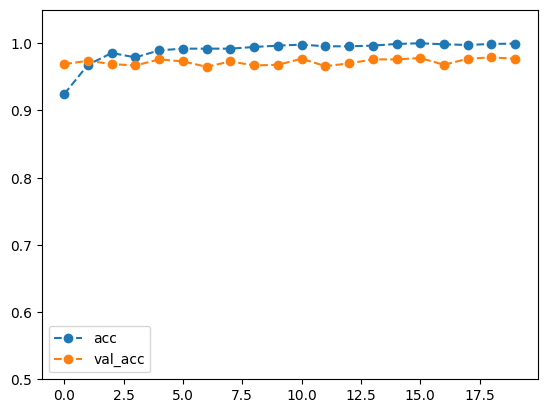

In [27]:
train_results[['acc', 'val_acc']].plot(style='o--')
plt.ylim(0.5, 1.05)

## 기반 모델과 데이터 증식

In [28]:
from tensorflow.keras import layers

data_augment = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1), 
    layers.RandomZoom(0.2)
], name='data_augment')

def create_model(base_model):
    model = keras.Sequential([
        keras.Input(shape=(180, 180, 3)), 
        data_augment, 
        # keras.applications.vgg16.preprocess_input(x)
        # 전처리
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'), 
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid', name='prediction')
    ])
    return model

conv_base.trainable = False
create_model(base_model=conv_base).summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augment (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 12800)             0         
                                                                 
 dense_1 (Dense)             (None, 256)               3277056   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 prediction (Dense)          (None, 1)                 257       
                                                                 
Total params: 17,992,001
Trainable params: 3,277,313
N

In [29]:
from tensorflow.keras import layers

data_augment = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1), 
    layers.RandomZoom(0.2)
], name='data_augment')

def create_model(base_model):
    inputs = keras.Input(shape=(180, 180, 3))
    x = data_augment(inputs) 
    x = keras.applications.vgg16.preprocess_input(x)
    x = base_model(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x) 
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid', name='prediction')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

conv_base.trainable = False
model = create_model(base_model=conv_base)
model.summary()

model.compile(loss=losses.binary_crossentropy, optimizer='rmsprop', 
                 metrics=['acc'])

history = model.fit(train_dataset, epochs=20, 
                    validation_data=validation_dataset, callbacks=[
    checkpoint_callback('../checkpoints/cats_and_dogs_vgg16_base_augmented.keras')
])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 data_augment (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 180, 180, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 12800)             0         
                                                             

In [30]:
train_results = pd.DataFrame(history.history)
train_results[-3:]

,loss,acc,val_loss,val_acc
17,0.234744,0.9825,0.440006,0.978
18,0.130560,0.9820,0.741135,0.975
19,0.176697,0.9840,0.551401,0.980


In [31]:
train_results['val_acc'].max()

0.9810000061988831

(0.5, 1.05)

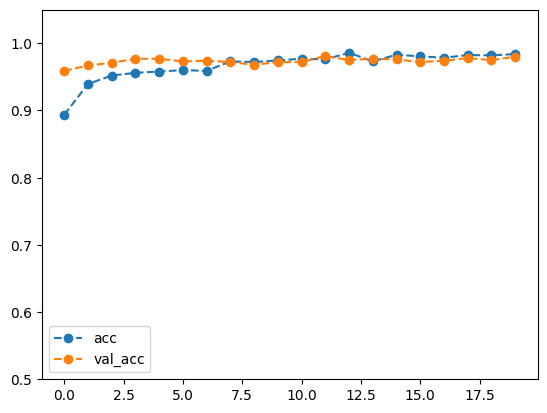

In [32]:
train_results[['acc', 'val_acc']].plot(style='o--')
plt.ylim(0.5, 1.05)

## 미세 조정(File Tuning)

In [33]:
np.arange(10)[:-5]

array([0, 1, 2, 3, 4])

In [34]:
from tensorflow.keras import layers

conv_base = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(180, 180, 3))

# 미세 조정을 위해 고층부를 훈련 가능하도록 설정
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False
    
model = create_model(base_model=conv_base)
model.summary()

model.compile(loss=losses.binary_crossentropy,
              optimizer=optimizers.RMSprop(learning_rate=1e-5), 
              metrics=['acc'])
history = model.fit(train_dataset, epochs=30, 
                    validation_data=validation_dataset, 
  callbacks=[checkpoint_callback('./checkpoints/cats_and_dogs_vgg16_base_augmented_fine_tuning.keras')]
                   )

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 data_augment (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 180, 180, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 180, 180, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 12800)             0   

In [35]:
train_results = pd.DataFrame(history.history)
train_results[-3:]

,loss,acc,val_loss,val_acc
27,0.022873,0.992,0.102024,0.982
28,0.038234,0.990,0.109034,0.978
29,0.024651,0.992,0.095942,0.980


In [36]:
train_results['val_acc'].max()

0.9829999804496765

(0.5, 1.05)

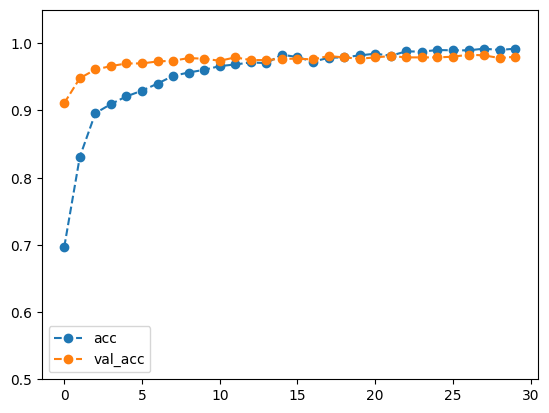

In [37]:
train_results[['acc', 'val_acc']].plot(style='o--')
plt.ylim(0.5, 1.05)

## 오후 수업

In [38]:
a = input('정수 입력')
print(a)

정수 입력 100


100


In [39]:
from tensorflow.keras.utils import image_dataset_from_directory

# train_dataset = image_dataset_from_directory('./data/cats_and_dogs_filtered/train/')
train_dataset = image_dataset_from_directory(
    'data/cats_and_dogs_filtered/train/', 
    image_size=(180, 180), batch_size=32)

validation_dataset = image_dataset_from_directory(
    'data/cats_and_dogs_filtered/validation/',
    image_size=(180, 180), batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


## 이미지 분할

In [40]:
import sys
import os

fd_path ='./data/oxford-pet/images'
img_lst = []
for fname in os.listdir(fd_path):
    if fname.endswith('.jpg'):
        fpath = os.path.join(fd_path, fname)
        img_lst.append(fpath)
        
lb_path = './data/oxford-pet/annotations/trimaps'
target_paths = []
for fname in os.listdir(lb_path):
    if fname.endswith('.png') and not fname.startswith('.'):
        fpath = os.path.join(lb_path, fname)
        target_paths.append(fpath)
    
img_lst = sorted(img_lst)        
target_paths = sorted(target_paths)

파일명_획득 = lambda filepath: os.path.basename(filepath).split('.')[0]
fnames1 = [파일명_획득(fname) for fname in img_lst]
fnames2 = [파일명_획득(fname) for fname in target_paths]
assert np.all(fnames1 == fnames2), '오류! 파일쌍 불일치'
assert len(img_lst) == len(target_paths), '오류! 파일 개수 불일치'

In [41]:
len(img_lst)

7390

In [42]:
img_lst[:3]

['./data/oxford-pet/images\\Abyssinian_1.jpg',
 './data/oxford-pet/images\\Abyssinian_10.jpg',
 './data/oxford-pet/images\\Abyssinian_100.jpg']

In [43]:
len(target_paths)

7390

In [44]:
target_paths[:3]

['./data/oxford-pet/annotations/trimaps\\Abyssinian_1.png',
 './data/oxford-pet/annotations/trimaps\\Abyssinian_10.png',
 './data/oxford-pet/annotations/trimaps\\Abyssinian_100.png']

In [45]:
from tensorflow.keras.utils import load_img, img_to_array

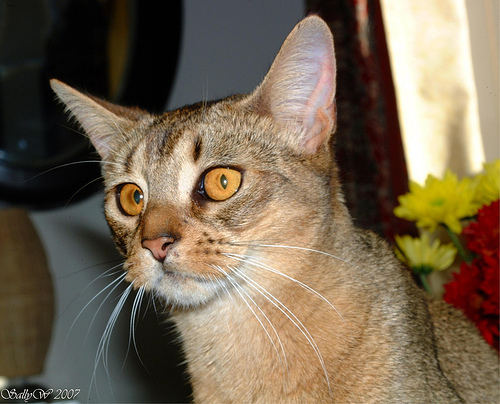

In [46]:
load_img(img_lst[10])

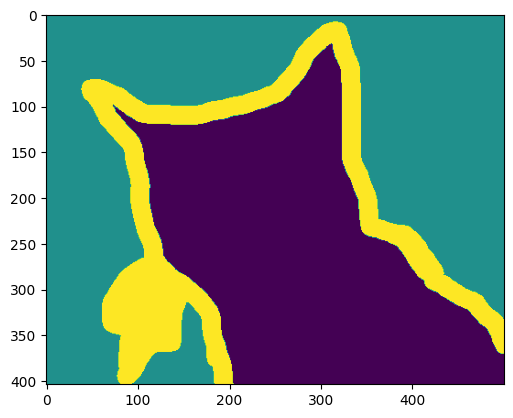

In [47]:
normalize_mask = lambda img_mask: img_mask.astype('uint8') - 1

y1 = img_to_array(load_img(target_paths[10], color_mode='grayscale'))
y1 = normalize_mask(y1)

plt.imshow(y1 * 127)

In [48]:
y1.shape

(404, 500, 1)

In [49]:
np.unique(y1)

array([0, 1, 2], dtype=uint8)

이미지와 분할 마스크를 모델의 입력 데이터로 준비하기

In [50]:
img_size = (200, 200)

xs = []
for filepath in img_lst:
    xi = img_to_array(load_img(filepath, target_size=img_size))
    xs.append(xi)

ys = []
for filepath in target_paths:
    yi = img_to_array(load_img(filepath, target_size=img_size, color_mode='grayscale'))
    yi = normalize_mask(yi)
    ys.append(yi)

assert len(xs) == len(ys)

In [51]:
input_imgs = np.stack(xs, axis=0)
targets = np.stack(ys, axis=0)
input_imgs.shape, targets.shape

((7390, 200, 200, 3), (7390, 200, 200, 1))

In [52]:
from sklearn.model_selection import train_test_split

train_imgs, val_imgs, train_targets, val_targets = train_test_split(
    input_imgs, targets, shuffle=True, test_size=1000, random_state=1337)

In [53]:
train_imgs.shape, val_imgs.shape

((6390, 200, 200, 3), (1000, 200, 200, 3))

In [54]:
def get_model(img_size, num_classes):
    model = keras.Sequential([
        keras.Input(shape=img_size), 
        layers.Rescaling(1./255), 
        
        layers.Conv2D(64, kernel_size=3, strides=2, activation='relu', padding='same'),
        layers.Conv2D(64, kernel_size=3, strides=1, activation='relu', padding='same'),
        layers.Conv2D(64 * 2, kernel_size=3, strides=2, activation='relu', padding='same'),
        layers.Conv2D(64 * 2, kernel_size=3, strides=1, activation='relu', padding='same'),
        layers.Conv2D(64 * 4, kernel_size=3, strides=2, activation='relu', padding='same'),
        layers.Conv2D(64 * 4, kernel_size=3, strides=1, activation='relu', padding='same'),
        
        # up sampling 
        layers.Conv2DTranspose(64 * 4, kernel_size=3, strides=1, activation='relu', padding='same'),
        layers.Conv2DTranspose(64 * 4, kernel_size=3, strides=2, activation='relu', padding='same'),
        layers.Conv2DTranspose(64 * 2, kernel_size=3, strides=1, activation='relu', padding='same'),
        layers.Conv2DTranspose(64 * 2, kernel_size=3, strides=2, activation='relu', padding='same'),
        layers.Conv2DTranspose(64 * 1, kernel_size=3, strides=1, activation='relu', padding='same'),
        layers.Conv2DTranspose(64 * 1, kernel_size=3, strides=2, activation='relu', padding='same'),
        # output
        layers.Conv2D(num_classes, kernel_size=3, activation='softmax', padding='same')
    ])
    return model

In [55]:
from tensorflow import keras

keras.backend.clear_session() # 이전 메모리 정리

model = get_model(img_size=(200, 200, 3), num_classes=3)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168    
                                                                 
 conv2d_5 (Conv2D)           (None, 25, 25, 256)       5

In [56]:
def checkpoint_callback(checkpoint_path):
    return keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss')

In [57]:
keras.backend.clear_session() # 이전 메모리 정리

from sklearn.model_selection import train_test_split

train_imgs, val_imgs, train_targets, val_targets = train_test_split(
    input_imgs, targets, shuffle=True, test_size=1000, random_state=1337)

model.compile(loss=losses.sparse_categorical_crossentropy, 
              optimizer='rmsprop')

history = model.fit(train_imgs, train_targets, epochs=50, batch_size=64, 
          validation_data=(val_imgs, val_targets), 
          callbacks=[checkpoint_callback('./checkpoints/oxford_segmentation.keras')]) 

Epoch 1/50


ResourceExhaustedError: Graph execution error:

Detected at node 'sequential/conv2d_transpose_5/conv2d_transpose' defined at (most recent call last):
    File "C:\Users\PC\.conda\envs\pydeep\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\PC\.conda\envs\pydeep\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\PC\.conda\envs\pydeep\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\PC\.conda\envs\pydeep\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\PC\.conda\envs\pydeep\lib\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "C:\Users\PC\.conda\envs\pydeep\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\PC\.conda\envs\pydeep\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\PC\.conda\envs\pydeep\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\PC\.conda\envs\pydeep\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\PC\.conda\envs\pydeep\lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "C:\Users\PC\.conda\envs\pydeep\lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "C:\Users\PC\.conda\envs\pydeep\lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "C:\Users\PC\.conda\envs\pydeep\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\PC\.conda\envs\pydeep\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\PC\.conda\envs\pydeep\lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\PC\.conda\envs\pydeep\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "C:\Users\PC\.conda\envs\pydeep\lib\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "C:\Users\PC\.conda\envs\pydeep\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\PC\.conda\envs\pydeep\lib\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\PC\.conda\envs\pydeep\lib\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\PC\.conda\envs\pydeep\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\PC\AppData\Local\Temp\ipykernel_18512\3704962139.py", line 11, in <module>
      history = model.fit(train_imgs, train_targets, epochs=50, batch_size=64,
    File "C:\Users\PC\.conda\envs\pydeep\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\PC\.conda\envs\pydeep\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\PC\.conda\envs\pydeep\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "C:\Users\PC\.conda\envs\pydeep\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\PC\.conda\envs\pydeep\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "C:\Users\PC\.conda\envs\pydeep\lib\site-packages\keras\engine\training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\PC\.conda\envs\pydeep\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\PC\.conda\envs\pydeep\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\PC\.conda\envs\pydeep\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\PC\.conda\envs\pydeep\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\PC\.conda\envs\pydeep\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\PC\.conda\envs\pydeep\lib\site-packages\keras\engine\sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "C:\Users\PC\.conda\envs\pydeep\lib\site-packages\keras\engine\functional.py", line 458, in call
      return self._run_internal_graph(
    File "C:\Users\PC\.conda\envs\pydeep\lib\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\PC\.conda\envs\pydeep\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\PC\.conda\envs\pydeep\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\PC\.conda\envs\pydeep\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\PC\.conda\envs\pydeep\lib\site-packages\keras\layers\convolutional\conv2d_transpose.py", line 275, in call
      outputs = backend.conv2d_transpose(
    File "C:\Users\PC\.conda\envs\pydeep\lib\site-packages\keras\backend.py", line 5756, in conv2d_transpose
      x = tf.compat.v1.nn.conv2d_transpose(x, kernel, output_shape, strides,
Node: 'sequential/conv2d_transpose_5/conv2d_transpose'
OOM when allocating tensor with shape[64,64,201,201] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential/conv2d_transpose_5/conv2d_transpose}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_45729]

In [58]:
from sklearn.model_selection import train_test_split

train_imgs, val_imgs, train_targets, val_targets = train_test_split(
    input_imgs, targets, shuffle=True, test_size=1000, random_state=1337)

keras.backend.clear_session() # 이전 메모리 정리
model = get_model(img_size=(200, 200, 3), num_classes=3)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168    
                                                                 
 conv2d_5 (Conv2D)           (None, 25, 25, 256)       5

In [59]:
keras.backend.clear_session() # 이전 메모리 정리

model.compile(loss=losses.sparse_categorical_crossentropy, optimizer='rmsprop')
history = model.fit(train_imgs, train_targets, epochs=50, batch_size=64, 
                    validation_data=(val_imgs, val_targets), callbacks=[
                    checkpoint_callback('./checkpoints/oxford_segmentation.keras')
                    ])

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.